In [16]:
curr_dir = '/user_data/vayzenbe/GitHub_Repos/goodale-milner-test'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
vone_dir = '/user_data/vayzenbe/GitHub_Repos/vonenet'
cornet_dir = '/user_data/vayzenbe/GitHub_Repos/CORnet'

sys.path.insert(1, vone_dir)
sys.path.insert(1, cornet_dir)
import vonenet
import cornet

import torch

import torch.nn as nn
import torchvision
from torchvision.models import resnet18, alexnet, vgg19, vgg11

import load_stim
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import svm

import warnings
warnings.filterwarnings('ignore')


In [17]:
splits = 30


transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                 std=[0.5, 0.5, 0.5]),
            ])

In [18]:
def load_model(model_arch):   
    if model_arch =='cornet_z':
        model = cornet.get_model('z', pretrained=True, map_location=torch.device('cpu')).module
        layer_call = "getattr(getattr(model,'decoder'),'avgpool')"

    elif model_arch =='cornet_s':
        model = cornet.get_model('z', pretrained=True, map_location=torch.device('cpu')).module
        layer_call = "getattr(getattr(model,'decoder'),'avgpool')"

    elif model_arch =='alexnet':
        model = alexnet(pretrained=True)
        layer_call = "getattr(getattr(model,'classifier'),'4')"

    elif model_arch =='vgg19':
        model = vgg19(pretrained=True)
        layer_call = "getattr(getattr(model,'classifier'),'4')"

    elif model_arch =='resnet18':
        model = resnet18(pretrained=True)
        layer_call = "getattr(model,'avgpool')"
        
    return model, layer_call

In [19]:
def extract_acts(model, image_dir, transform, layer_call):
    print('extracting features...')
    

    #set up hook to specified layer
    def _store_feats(layer, inp, output):
        """An ugly but effective way of accessing intermediate model features
        """
        #avgpool = nn.AdaptiveAvgPool2d(output_size=(1,768))
        #output = avgpool(output)
        

        output = output.cpu().numpy()
        
        _model_feats.append(np.reshape(output, (len(output), -1)))

    try:
        m = model.module
    except:
        m = model
    #model_layer = getattr(getattr(m, layer), sublayer)
    model_layer = eval(layer_call)
    model_layer.register_forward_hook(_store_feats)



    #Iterate through each image and extract activations

    imNum = 0
    n=0

    

    test_dataset =torchvision.datasets.ImageFolder(image_dir, transform=transform)

    #test_dataset = load_stim.load_stim(image_dir, transform=transform)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers = 4, pin_memory=True)
    


    with torch.no_grad():
        
        for data, _ in testloader:
            # move tensors to GPU if CUDA is available
            
            #data= data.cuda()
            
            _model_feats = []
            model(data)
            #output = model(data)
            
            out = np.vstack(_model_feats)
            

            if n == 0:
                acts = out
                #label_list = label
            else:
                acts= np.append(acts, out,axis = 0)
                #label_list = np.append(label_list, label)
                
            
            n = n + 1

    return acts

In [20]:
def classify(acts, labels, splits):

    sss = StratifiedShuffleSplit(n_splits=splits, test_size=0.2)
    #run classifier
    acc = np.zeros(splits)
    for i, (train_index, test_index) in enumerate(sss.split(acts, labels)):
        X_train, X_test = acts[train_index], acts[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        clf = svm.SVC()
        clf.fit(X_train, y_train)
        acc[i] = clf.score(X_test, y_test)
        
        

    return acc

extracting features...


Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /home/vayzenbe/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:36<00:00, 14.4MB/s] 


extracting features...
extracting features...
extracting features...
extracting features...


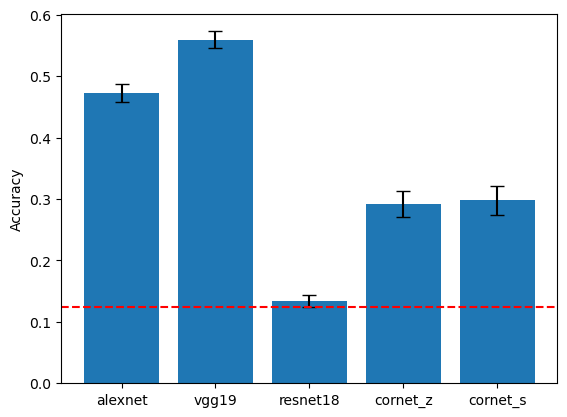

In [21]:
'''
Run for all stim
'''

stim_dir = f'{curr_dir}/stim/orient'

cat_num = 8
exemplar_num = 18
#create list of labels
#create list of 8 categerories of 24 exemplars each
labels = np.asanyarray([np.zeros(exemplar_num) + i for i in range(cat_num)])
labels = labels.flatten()

models = ['alexnet','vgg19','resnet18','cornet_z','cornet_s']
model_df = pd.DataFrame(columns = models)
for model_arch in models:
    model, layer_call = load_model(model_arch)

    acts = extract_acts(model, stim_dir, transform, layer_call)
    
    acc = classify(acts, labels, splits)

    model_df[model_arch] = acc

#plot acc and SE for all models
fig, ax = plt.subplots()
plt.bar(model_df.columns, model_df.mean())
plt.errorbar(np.arange(len(model_df.mean())), model_df.mean(), yerr=model_df.sem(),color='k', linestyle='None', capsize=5)


ax.set_ylabel('Accuracy')

#add horizontal line at chance
ax.axhline(y=1/cat_num, color='r', linestyle='--')


extracting features...
extracting features...
extracting features...
extracting features...
extracting features...


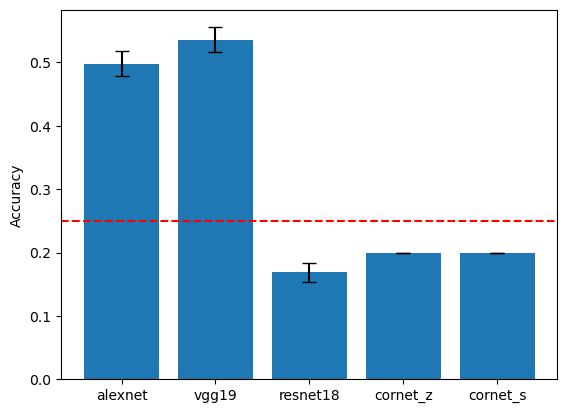

In [22]:
'''
Run for curved stim
'''

stim_dir = f'{curr_dir}/stim/curv'

cat_num = 4
exemplar_num = 18
#create list of labels
#create list of 8 categerories of 24 exemplars each
labels = np.asanyarray([np.zeros(exemplar_num) + i for i in range(cat_num)])
labels = labels.flatten()

models = ['alexnet','vgg19','resnet18','cornet_z','cornet_s']
model_df = pd.DataFrame(columns = models)
for model_arch in models:
    model, layer_call = load_model(model_arch)

    acts = extract_acts(model, stim_dir, transform, layer_call)
    
    acc = classify(acts, labels, splits)

    model_df[model_arch] = acc

#plot acc and SE for all models
fig, ax = plt.subplots()
plt.bar(model_df.columns, model_df.mean())
plt.errorbar(np.arange(len(model_df.mean())), model_df.mean(), yerr=model_df.sem(),color='k', linestyle='None', capsize=5)


ax.set_ylabel('Accuracy')

#add horizontal line at chance
ax.axhline(y=1/cat_num, color='r', linestyle='--')


extracting features...
extracting features...
extracting features...
extracting features...
extracting features...


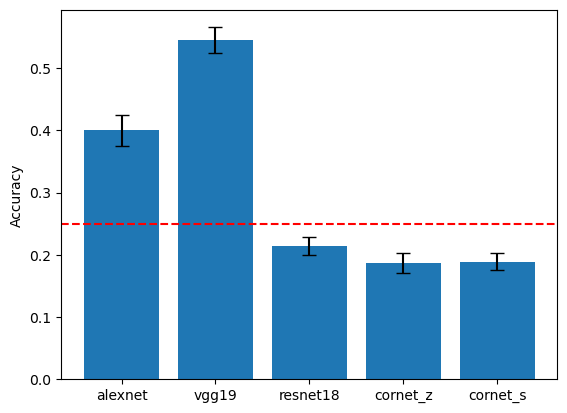

In [23]:
'''
Run for all rect stim
'''

stim_dir = f'{curr_dir}/stim/rect'

cat_num = 4
exemplar_num = 18
#create list of labels
#create list of 8 categerories of 24 exemplars each
labels = np.asanyarray([np.zeros(exemplar_num) + i for i in range(cat_num)])
labels = labels.flatten()

models = ['alexnet','vgg19','resnet18','cornet_z','cornet_s']
model_df = pd.DataFrame(columns = models)
for model_arch in models:
    model, layer_call = load_model(model_arch)

    acts = extract_acts(model, stim_dir, transform, layer_call)
    
    acc = classify(acts, labels, splits)

    model_df[model_arch] = acc

#plot acc and SE for all models
fig, ax = plt.subplots()
plt.bar(model_df.columns, model_df.mean())
plt.errorbar(np.arange(len(model_df.mean())), model_df.mean(), yerr=model_df.sem(),color='k', linestyle='None', capsize=5)


ax.set_ylabel('Accuracy')

#add horizontal line at chance
ax.axhline(y=1/cat_num, color='r', linestyle='--')


In [11]:
#create correlation matrix for activations
corr = np.corrcoef(acts)

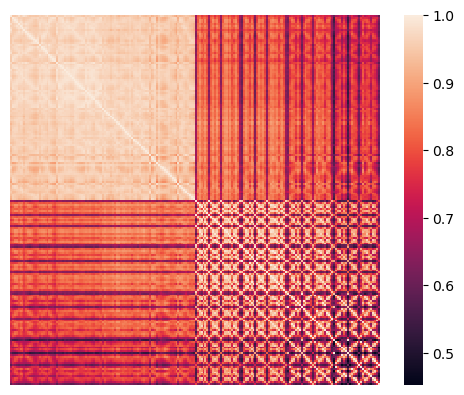

In [12]:
sns.heatmap(corr, cbar=True)

#remove axis labels
plt.xticks([])
plt.yticks([])

#remove tick lines
plt.tick_params(left=False, bottom=False)

#make square
plt.gca().set_aspect('equal', adjustable='box')


#save figure
plt.savefig('corr_matrix.png', dpi=300, bbox_inches='tight')


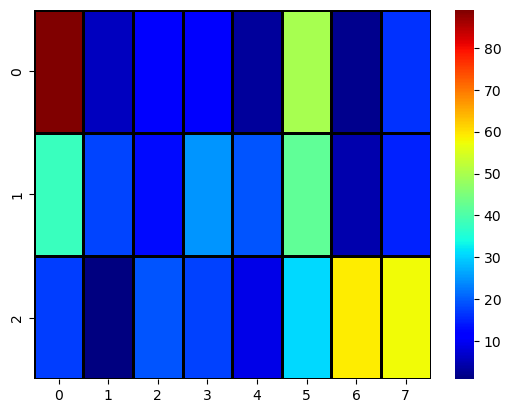

In [20]:


#create heatmap with seaborn
#add linse between cells
ax = sns.heatmap(acts, linewidths=1, cmap='jet', linecolor='black')
